<h3 style="color:blue;"><b>DATA PRE-PROCESSING</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Load dataset
df = pd.read_excel('/Users/johnharmer/Library/CloudStorage/GoogleDrive-jwharmeriv@gmail.com/My Drive/Springboard - Data Science/Capstone Projects/Capstone 3/Customer Segmentation Project/data/raw/Online Retail.xlsx')

In [3]:
# Load 10 rows to review DataFrame.
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
# Check for missing values in df.
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Drop rows with missing 'CustomerID'.
df = df.dropna(subset=['CustomerID'])

In [6]:
# Confirm missing values are removed from 'CustomerID'.
missing_values_clean = df.isnull().sum()
missing_values_clean

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.shape

(406829, 8)

In [8]:
# Check for duplicates
duplicates = df.duplicated().sum()

# Get data_types of each column.
data_types = df.dtypes

duplicates, data_types

(5225,
 InvoiceNo              object
 StockCode              object
 Description            object
 Quantity                int64
 InvoiceDate    datetime64[ns]
 UnitPrice             float64
 CustomerID            float64
 Country                object
 dtype: object)

In [9]:
# Remove duplicate rows from the df.
df = df.drop_duplicates()

# Confirum duplicate rows have been removed.
df_dedupe = df.shape

df_dedupe

(401604, 8)

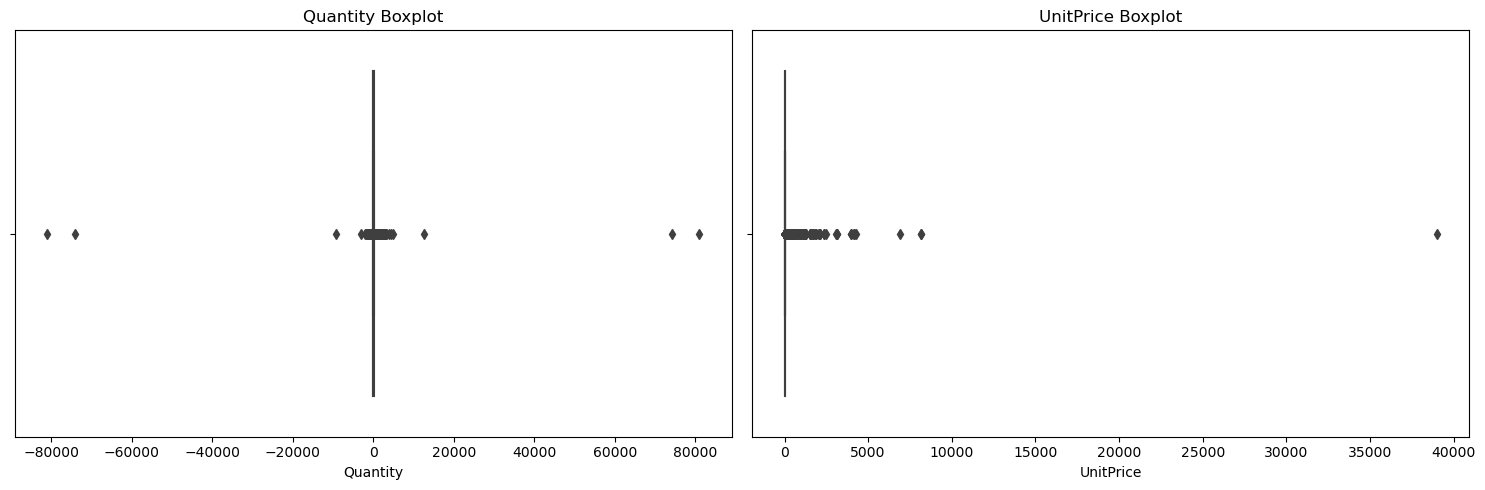

In [10]:
# Plot boxplots to visually identify outliers in 'Quantity' and 'UnitPrice'.
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Quantity'])
plt.title('Quantity Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['UnitPrice'])
plt.title('UnitPrice Boxplot')

plt.tight_layout()
plt.show()

In [11]:
# Look for rows with negative values in 'Quantity'.
negative_qty_rows = df[df['Quantity'] < 0]
negative_qty_rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [12]:
# Count how many rows in 'Quantity' have negative values.
count_negative_rows = negative_qty_rows['Quantity'].sum()
count_negative_rows

-273035

After reviewing the negative values in *'Quantity'*, I will make them positive instead of dropping them. It is impossible to sell a negative quantity, and many of the quantities "make sense" because the quanities match pack quantities (i.e. "pack of 12" and the quantity sold was 24, indicated 2 packs were sold).

In [13]:
# Convert negative values in 'Quantity' to positive.
df['Quantity'] = df['Quantity'].abs()

# Confirm negative values are changed to positive.
df.loc[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


It may be worth removing some StockCode's like *'D'* or *'M'*. Look for other unique StockCode's to see what others are there.

In [14]:
# Filter for StockCodes that only contain letters, excluding NaNs
stockcodes_only_letters = df[df['StockCode'].notna() & df['StockCode'].str.isalpha()]

# Display the unique StockCodes that contain only letters
unique_stockcodes_only_letters = stockcodes_only_letters['StockCode'].unique()

unique_stockcodes_only_letters

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [15]:
# Filter the rows that have StockCode values in the list ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
alpha_stockcodes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
rows_with_alpha_stockcodes = df[df['StockCode'].isin(alpha_stockcodes)]

# Display the descriptions of these rows
rows_with_alpha_stockcodes[['StockCode', 'Description']]

,StockCode,Description
45,POST,POSTAGE
141,D,Discount
386,POST,POSTAGE
1123,POST,POSTAGE
2239,M,Manual
...,...,...
541216,POST,POSTAGE
541541,M,Manual
541730,POST,POSTAGE
541767,POST,POSTAGE


I discovered that *'D'= Discount, 'M'= Manual, 'POST'= Postage, 'PADS'= Pads to match all cushions, 'DOT'= Dotcom postage, 'CRUK'= CRUK Commission*. It's best to drop all of these StockCodes including 'PADS'. 'PADS' always come in a quantity of 1 and are a child in a parent child relationship. The most important StockCode is the parent's because the cushions will not be sold unless the parent StockCode is purchased.

In [16]:
# Filter out rows containing 'D', 'M', 'POST', 'DOT', 'CRUK'.
stockcodes_to_exclude = ['D', 'M', 'PADS', 'POST', 'DOT', 'CRUK']
df = df[~df['StockCode'].isin(stockcodes_to_exclude)]

# Display the first few rows of the filtered DataFrame
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
# Review 'UnitPrice' again for outliers.
df['UnitPrice'].sort_values(ascending=False)

222680    649.5
222682    649.5
133994    295.0
36165     295.0
82768     295.0
          ...  
436597      0.0
145208      0.0
86789       0.0
420404      0.0
454463      0.0
Name: UnitPrice, Length: 399835, dtype: float64

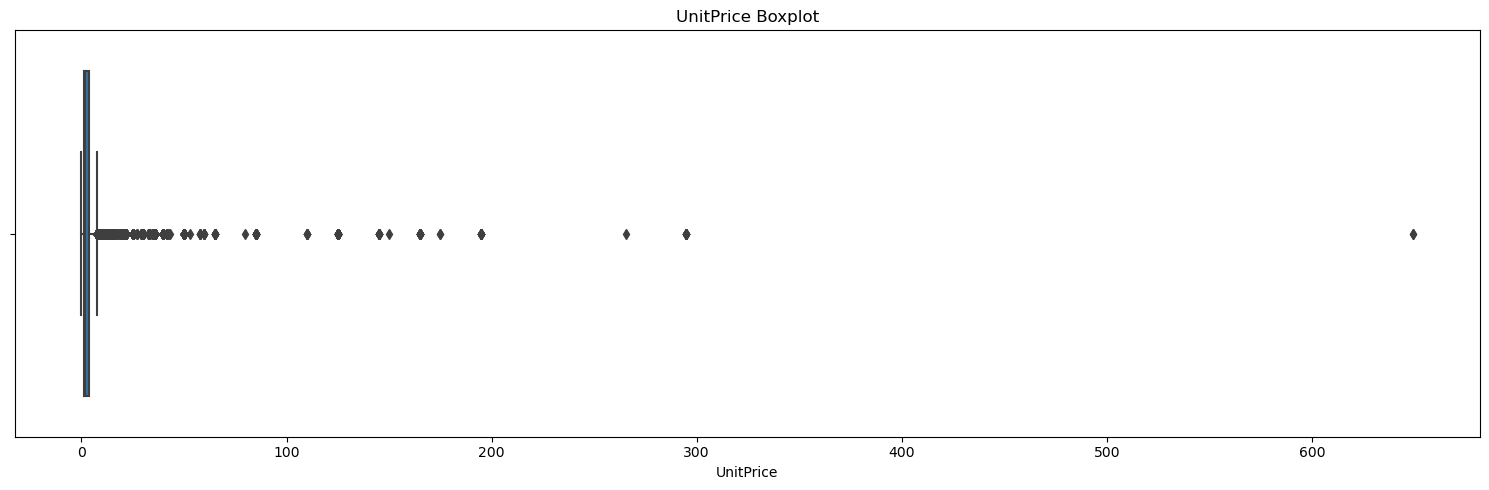

In [18]:
# Plot boxplot to visually identify outliers in 'UnitPrice'.
plt.figure(figsize=(15,5))

sns.boxplot(x=df['UnitPrice'])
plt.title('UnitPrice Boxplot')

plt.tight_layout()
plt.show()

After removing the alpha only stockcodes, it has resolved the big outlier of ~$39,000. I feel good about now moving forward with creating some additional variables such as *Amount*, *Recency*, *Frequency*, and *Monetary*.

In [19]:
# Create an aggregated variable named 'Amount'
df['Amount'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
# Separate 'InvoiceDate' from df into two variables 'Date' and 'Time' to allow for the creation of the variables 'Recency', 'Frequency', 
# and 'Monetary'.
df['Date'] = df['InvoiceDate'].dt.date
df['Time'] = df['InvoiceDate'].dt.time

# Drop 'InvoiceDate' column.
df = df.drop(columns=['InvoiceDate'])

# Display the first few rows to verify the changes
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Amount,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


In [21]:
# Check for any errors or inconsistencies in 'Date' and 'Time' columns
# Verify unique values and their data types
date_unique_values = df['Date'].unique()
time_unique_values = df['Time'].unique()

# Summary of the Date and Time columns
date_summary = df['Date'].describe()
time_summary = df['Time'].describe()

(date_unique_values[:5], time_unique_values[:5], date_summary, time_summary)

(array([datetime.date(2010, 12, 1), datetime.date(2010, 12, 2),
        datetime.date(2010, 12, 3), datetime.date(2010, 12, 5),
        datetime.date(2010, 12, 6)], dtype=object),
 array([datetime.time(8, 26), datetime.time(8, 28), datetime.time(8, 34),
        datetime.time(8, 35), datetime.time(8, 45)], dtype=object),
 count         399835
 unique           305
 top       2011-12-05
 freq            3347
 Name: Date, dtype: object,
 count       399835
 unique         770
 top       13:35:00
 freq          1805
 Name: Time, dtype: object)

In [22]:
# Check for unique CustomerID values in the DataFrame
unique_customer_ids = df['CustomerID'].unique()

# Display the number of unique CustomerIDs
num_unique_customer_ids = len(unique_customer_ids)

num_unique_customer_ids

4363

In [23]:
# Prepare the Data for RFM Analysis
# Set a reference date for calculating Recency (e.g., day after the last date in the dataset)
reference_date = df['Date'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate RFM metrics
rfm_df = df.groupby('CustomerID').agg({
    'Date': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # 
    'Amount': 'sum'  # Monetary
}).reset_index()

# Rename columns for RFM
rfm_df.rename(columns={'Date': 'Recency', 'InvoiceNo': 'Frequency', 'Amount': 'Monetary'}, inplace=True)

# Display the RFM DataFrame
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,154367.20
1,12347.0,3,7,4310.00
2,12348.0,76,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,311,1,294.40


In [24]:
# Confirm 'Monetary' for CustomerID 12346.0
df[df['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Amount,Date,Time
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,77183.6,2011-01-18,10:01:00
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,77183.6,2011-01-18,10:17:00


<h3 style="color:blue;"><b>EXPLORATORY DATA ANALYSIS</h3>

array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'UnitPrice'}>],
       [<Axes: title={'center': 'Amount'}>, <Axes: >]], dtype=object)

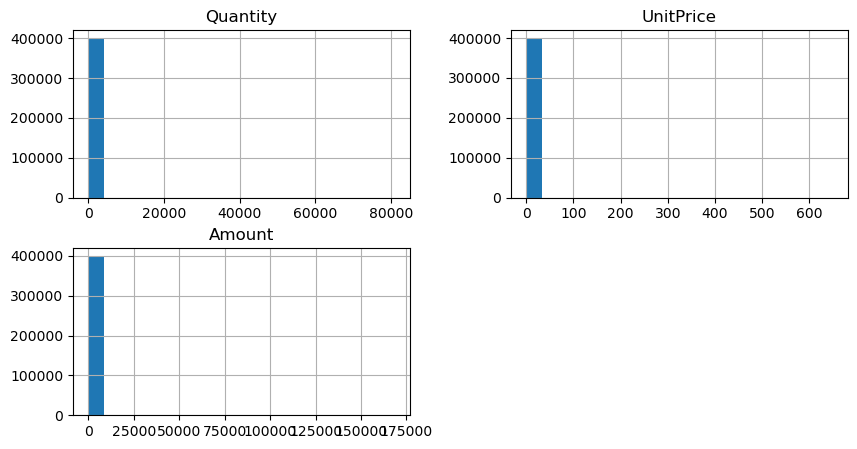

In [26]:
df[['Quantity', 'UnitPrice', 'Amount']].hist(figsize=(10, 5), bins=20)


array([[<Axes: title={'center': 'Quantity_log'}>,
        <Axes: title={'center': 'UnitPrice_log'}>],
       [<Axes: title={'center': 'Amount_log'}>, <Axes: >]], dtype=object)

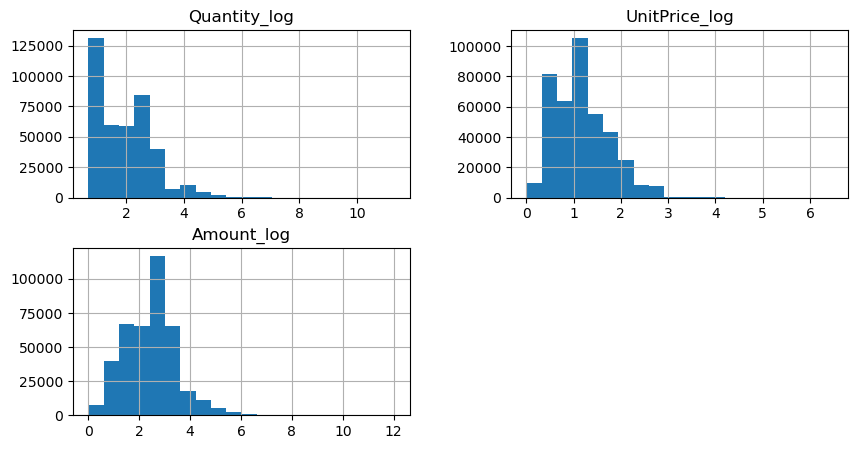

In [27]:
# It seems as most of the values are zero or near-zero indicating a small range, leading to a single, dense bin.
# Use log transformation to normalize the data.

df['Quantity_log'] = np.log1p(df['Quantity'])
df['UnitPrice_log'] = np.log1p(df['UnitPrice'])
df['Amount_log'] = np.log1p(df['Amount'])

df[['Quantity_log', 'UnitPrice_log', 'Amount_log']].hist(figsize=(10, 5), bins=20)
